### Device Initialization

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


### Data Preparation

In [41]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    T.Lambda(torch.flatten)
])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./data', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./data', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./data', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

In [3]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones Networks

In [42]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass;
    PyTorch will take care of the backward pass for us.

    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]

    w1, w2 = params

    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x


def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


In [43]:
import torch.nn.functional as F  # useful stateless functions

def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?

    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    # Reshape input from [N, 3072] to [N, 3, 32, 32] if needed
    if x.dim() == 2:
        N = x.shape[0]
        x = x.view(N, 3, 32, 32)

    x = F.relu(F.conv2d(x, conv_w1, conv_b1, padding=2))
    x = F.relu(F.conv2d(x, conv_w2, conv_b2, padding=1))
    scores = flatten(x).mm(fc_w) + fc_b
  
    return scores

In [44]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


In [45]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])

    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)


In [46]:

print(random_weight((3, 5)))
print(zero_weight((3, 5)))

tensor([[-0.5589,  0.0766,  0.1791, -1.2257, -0.2844],
        [ 1.0719,  0.8587, -0.1794, -0.7320, -0.5703],
        [ 0.9430, -0.3226,  1.5046, -1.0308, -1.3763]], requires_grad=True)
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)


In [47]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In [48]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.

    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD

    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

In [49]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.0087
Checking accuracy on the val set
Got 137 / 1000 correct (13.70%)

Iteration 100, loss = 1.7709
Checking accuracy on the val set
Got 349 / 1000 correct (34.90%)

Iteration 200, loss = 1.8830
Checking accuracy on the val set
Got 398 / 1000 correct (39.80%)

Iteration 300, loss = 1.7972
Checking accuracy on the val set
Got 384 / 1000 correct (38.40%)

Iteration 400, loss = 1.8761
Checking accuracy on the val set
Got 395 / 1000 correct (39.50%)

Iteration 500, loss = 1.8047
Checking accuracy on the val set
Got 404 / 1000 correct (40.40%)

Iteration 600, loss = 1.8477
Checking accuracy on the val set
Got 438 / 1000 correct (43.80%)

Iteration 700, loss = 1.5631
Checking accuracy on the val set
Got 409 / 1000 correct (40.90%)



In [50]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight(channel_1)
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight((channel_2))
fc_w = random_weight((channel_2 * 32 * 32, 10))
fc_b = zero_weight(10)

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.7998
Checking accuracy on the val set
Got 142 / 1000 correct (14.20%)

Iteration 100, loss = 1.7110
Checking accuracy on the val set
Got 373 / 1000 correct (37.30%)

Iteration 200, loss = 1.7206
Checking accuracy on the val set
Got 408 / 1000 correct (40.80%)

Iteration 300, loss = 1.7185
Checking accuracy on the val set
Got 426 / 1000 correct (42.60%)

Iteration 400, loss = 1.7888
Checking accuracy on the val set
Got 446 / 1000 correct (44.60%)

Iteration 500, loss = 1.6100
Checking accuracy on the val set
Got 443 / 1000 correct (44.30%)

Iteration 600, loss = 1.5445
Checking accuracy on the val set
Got 457 / 1000 correct (45.70%)

Iteration 700, loss = 1.5503
Checking accuracy on the val set
Got 469 / 1000 correct (46.90%)



## nn.Module API

In [52]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


In [67]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, channel_1, (5, 5), padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(channel_1, channel_2, (3, 3), padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)   

    def forward(self, x):
        scores = None
        if x.dim() == 2:
            N = x.shape[0]  
            x = x.view(N, 3, 32, 32)
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        scores = self.fc(flatten(x))
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


In [68]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [96]:
def compute_accuracy(loader, model, device=device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += y.size(0)
    return num_correct / num_samples

import matplotlib.pyplot as plt

def train_part34(model, optimizer, epochs=1, print_every=100):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Tracks:
      - per-iteration training loss
      - per-iteration validation accuracy
    Allows:
      - early stop via Ctrl+C
    Plots:
      - loss vs iteration
      - validation accuracy vs iteration
    """
    model = model.to(device=device)

    history = {
        "iter": [],
        "train_loss": [],
        "val_acc": [],
    }

    global_iter = 0

    try:
        for e in range(epochs):
            print("=" * 60)
            print(f"Epoch {e + 1}/{epochs}")
            print("=" * 60)

            model.train()

            for t, (x, y) in enumerate(loader_train):
                global_iter += 1

                x = x.to(device=device, dtype=dtype)
                y = y.to(device=device, dtype=torch.long)

                scores = model(x)
                loss = F.cross_entropy(scores, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if global_iter % print_every == 0:
                    # Record train loss
                    history["iter"].append(global_iter)
                    history["train_loss"].append(loss.item())

                    # Compute validation accuracy
                    val_acc = compute_accuracy(loader_val, model)
                    history["val_acc"].append(val_acc)

                    print(f"[Iter {global_iter}] loss = {loss.item():.4f}")
                    print(f"   validation accuracy: {val_acc * 100:.2f}%")

            print()

    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user. Plotting collected results...\n")

    finally:
        if len(history["iter"]) > 0:
            it = history["iter"]
            loss = history["train_loss"]
            acc  = [a * 100 for a in history["val_acc"]]

            plt.figure(figsize=(8, 5))

            # ---- Left axis: Loss ----
            ax1 = plt.gca()
            ax1.plot(it, loss, color='tab:red', marker='o', label='Training Loss')
            ax1.set_xlabel("Iteration")
            ax1.set_ylabel("Training Loss", color='tab:red')
            ax1.tick_params(axis='y', labelcolor='tab:red')
            
            # ---- Right axis: Accuracy ----
            ax2 = ax1.twinx()
            ax2.plot(it, acc, color='tab:blue', marker='o', label='Validation Accuracy')
            ax2.set_ylabel("Validation Accuracy (%)", color='tab:blue')
            ax2.tick_params(axis='y', labelcolor='tab:blue')

            # ---- Title & Grid ----
            plt.title("Training Loss & Validation Accuracy vs Iteration")
            ax1.grid(True)

            plt.show()

        else:
            print("No statistics collected; nothing to plot.")


    return history




Epoch 1/1
[Iter 100] loss = 1.9982
   validation accuracy: 34.50%
[Iter 200] loss = 2.1340
   validation accuracy: 37.90%
[Iter 300] loss = 1.8014
   validation accuracy: 41.90%
[Iter 400] loss = 1.9127
   validation accuracy: 43.40%
[Iter 500] loss = 1.5159
   validation accuracy: 42.00%
[Iter 600] loss = 1.8305
   validation accuracy: 43.10%
[Iter 700] loss = 1.5107
   validation accuracy: 45.70%



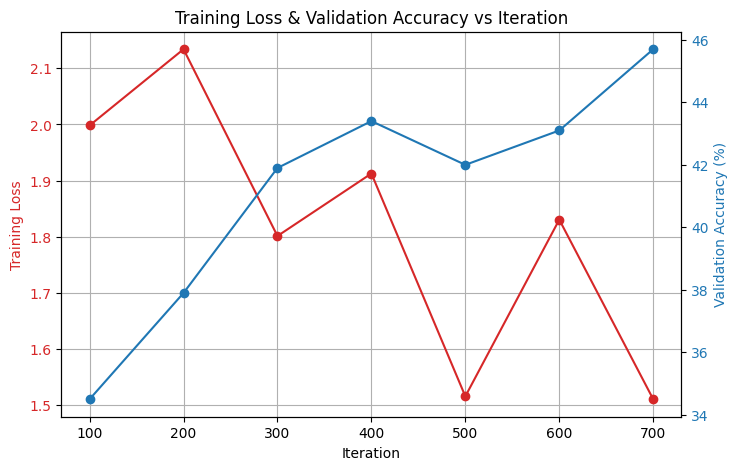

{'iter': [100, 200, 300, 400, 500, 600, 700],
 'train_loss': [1.9982287883758545,
  2.1340298652648926,
  1.801378607749939,
  1.9126732349395752,
  1.5158581733703613,
  1.8305057287216187,
  1.5107189416885376],
 'val_acc': [0.345, 0.379, 0.419, 0.434, 0.42, 0.431, 0.457]}

In [98]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Epoch 1/1
[Iter 100] loss = 1.7940
   validation accuracy: 32.30%
[Iter 200] loss = 1.9012
   validation accuracy: 39.00%
[Iter 300] loss = 1.5420
   validation accuracy: 40.70%
[Iter 400] loss = 1.7178
   validation accuracy: 42.20%
[Iter 500] loss = 1.6462
   validation accuracy: 45.30%
[Iter 600] loss = 1.5717
   validation accuracy: 46.60%
[Iter 700] loss = 1.3034
   validation accuracy: 47.00%



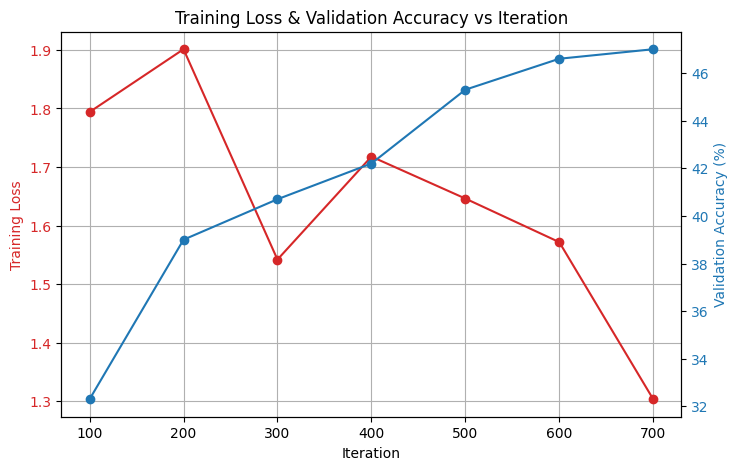

{'iter': [100, 200, 300, 400, 500, 600, 700],
 'train_loss': [1.7939730882644653,
  1.9012318849563599,
  1.541980266571045,
  1.7178339958190918,
  1.6461750268936157,
  1.5717217922210693,
  1.303430199623108],
 'val_acc': [0.323, 0.39, 0.407, 0.422, 0.453, 0.466, 0.47]}

In [99]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

## nn.Sequential API

Epoch 1/1
[Iter 100] loss = 1.9888
   validation accuracy: 38.80%
[Iter 200] loss = 1.5407
   validation accuracy: 42.10%
[Iter 300] loss = 1.5310
   validation accuracy: 44.20%
[Iter 400] loss = 2.0805
   validation accuracy: 43.40%
[Iter 500] loss = 1.5818
   validation accuracy: 44.10%
[Iter 600] loss = 1.3294
   validation accuracy: 45.30%
[Iter 700] loss = 1.6532
   validation accuracy: 43.90%



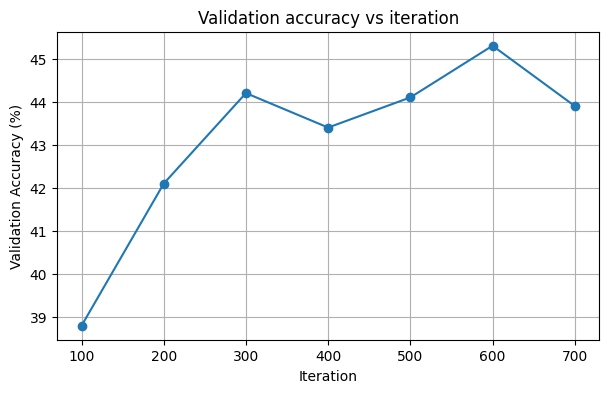

([100, 200, 300, 400, 500, 600, 700],
 [0.388, 0.421, 0.442, 0.434, 0.441, 0.453, 0.439])

In [91]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

# Experiments

### Base Model

In [92]:
class UnflattenCIFAR(nn.Module):
    def forward(self, x):
        # x: (N, 3072) -> (N, 3, 32, 32)
        return x.view(x.shape[0], 3, 32, 32)

Epoch 1/10
[Iter 100] loss = 1.8543
   validation accuracy: 43.90%
[Iter 200] loss = 1.5308
   validation accuracy: 50.00%
[Iter 300] loss = 1.4233
   validation accuracy: 51.20%
[Iter 400] loss = 1.1908
   validation accuracy: 54.70%
[Iter 500] loss = 1.3638
   validation accuracy: 55.10%
[Iter 600] loss = 1.2383
   validation accuracy: 59.00%
[Iter 700] loss = 1.2011
   validation accuracy: 57.10%

Epoch 2/10
[Iter 800] loss = 0.7556
   validation accuracy: 57.90%
[Iter 900] loss = 1.0016
   validation accuracy: 58.60%
[Iter 1000] loss = 1.2044
   validation accuracy: 58.40%
[Iter 1100] loss = 1.3564
   validation accuracy: 60.80%
[Iter 1200] loss = 1.0468
   validation accuracy: 60.30%
[Iter 1300] loss = 0.9343
   validation accuracy: 62.40%
[Iter 1400] loss = 1.0930
   validation accuracy: 60.80%
[Iter 1500] loss = 1.0605
   validation accuracy: 63.90%

Epoch 3/10
[Iter 1600] loss = 0.8942
   validation accuracy: 63.50%
[Iter 1700] loss = 0.9576
   validation accuracy: 61.00%
[Iter

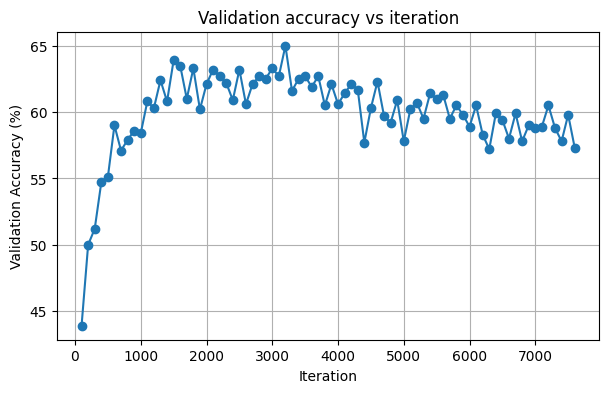

([100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 [0.439,
  0.5,
  0.512,
  0.547,
  0.551,
  0.59,
  0.571,
  0.579,
  0.586,
  0.584,
  0.608,
  0.603,
  0.624,
  0.608,
  0.639,
  0.635,
  0.61,
  0.633,
  0.602,
  0.621,
  0.632,
  0.627,
  0.622,
  0.609,
  0.632,
  0.606,
  0.621,
  0.627,
  0.625,
  0.633,
  0.627,
  0.65,
  0.616,
  0.625,
  0.627,
  0.619,
  0.627,
  0.605,
  0.621,
  0.606,
  0.614,
  0.621,
  0.617,
  0.577,
  0.603,


In [93]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = nn.Sequential(
    UnflattenCIFAR(),
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10)
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

################################################################################

train_part34(model, optimizer, epochs=10)

### Same architecture + ADAM

Epoch 1/10
[Iter 100] loss = 1.6186
   validation accuracy: 37.20%
[Iter 200] loss = 1.3983
   validation accuracy: 44.60%
[Iter 300] loss = 1.1906
   validation accuracy: 49.60%
[Iter 400] loss = 1.4571
   validation accuracy: 52.10%
[Iter 500] loss = 1.4354
   validation accuracy: 53.60%
[Iter 600] loss = 1.3719
   validation accuracy: 52.90%
[Iter 700] loss = 1.1444
   validation accuracy: 55.30%

Epoch 2/10
[Iter 800] loss = 1.0414
   validation accuracy: 56.00%
[Iter 900] loss = 1.0669
   validation accuracy: 58.30%
[Iter 1000] loss = 1.1100
   validation accuracy: 57.30%
[Iter 1100] loss = 1.2325
   validation accuracy: 55.10%
[Iter 1200] loss = 0.8728
   validation accuracy: 57.40%
[Iter 1300] loss = 1.2982
   validation accuracy: 59.50%
[Iter 1400] loss = 1.2344
   validation accuracy: 59.90%
[Iter 1500] loss = 1.1510
   validation accuracy: 59.80%

Epoch 3/10
[Iter 1600] loss = 0.9488
   validation accuracy: 58.50%
[Iter 1700] loss = 0.9526
   validation accuracy: 59.30%
[Iter

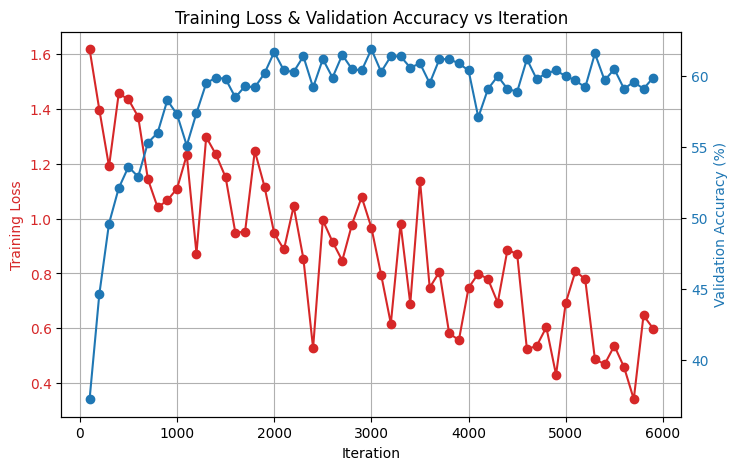

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900],
 'train_loss': [1.6185907125473022,
  1.3983135223388672,
  1.1906101703643799,
  1.4570833444595337,
  1.4353764057159424,
  1.3719366788864136,
  1.1444329023361206,
  1.0413883924484253,
  1.066884994506836,
  1.1099780797958374,
  1.2324589490890503,
  0.8728315830230713,
  1.2981603145599365,
  1.2344353199005127,
  1.151008129119873,
  0.9488359093666077,
  0.9526361227035522,
  1.2472600936889648,
  1.1172248125076294,
  0.9464671611785889,
  0.8875861167907715,
  1.0453053712844849,
  0.854096531867981,
  0.5276581

In [100]:
channel_1 = 32
channel_2 = 16
learning_rate = 0.0015

model = nn.Sequential(
    UnflattenCIFAR(),
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10)
)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

################################################################################

train_part34(model, optimizer, epochs=10)

### Batch norm + Dropout

Epoch 1/10
[Iter 100] loss = 1.7729
   validation accuracy: 37.70%
[Iter 200] loss = 1.3540
   validation accuracy: 49.70%
[Iter 300] loss = 1.3886
   validation accuracy: 52.90%
[Iter 400] loss = 1.3243
   validation accuracy: 53.90%
[Iter 500] loss = 1.1414
   validation accuracy: 53.00%
[Iter 600] loss = 1.3114
   validation accuracy: 54.90%
[Iter 700] loss = 1.0486
   validation accuracy: 56.60%

Epoch 2/10
[Iter 800] loss = 2.0237
   validation accuracy: 51.10%
[Iter 900] loss = 0.8819
   validation accuracy: 57.00%
[Iter 1000] loss = 1.1537
   validation accuracy: 59.20%
[Iter 1100] loss = 1.2563
   validation accuracy: 59.80%
[Iter 1200] loss = 0.9344
   validation accuracy: 58.00%
[Iter 1300] loss = 1.0880
   validation accuracy: 60.40%
[Iter 1400] loss = 1.1669
   validation accuracy: 60.60%
[Iter 1500] loss = 1.0041
   validation accuracy: 59.30%

Epoch 3/10
[Iter 1600] loss = 0.8987
   validation accuracy: 60.50%
[Iter 1700] loss = 1.1060
   validation accuracy: 62.60%
[Iter

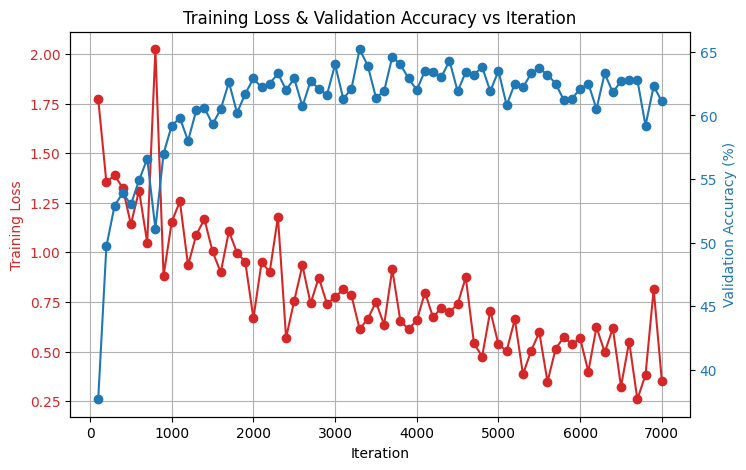

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000],
 'train_loss': [1.7729140520095825,
  1.3539671897888184,
  1.3886301517486572,
  1.3243305683135986,
  1.1414376497268677,
  1.3114197254180908,
  1.0485639572143555,
  2.023681640625,
  0.8818857669830322,
  1.1537249088287354,
  1.2562880516052246,
  0.9344345331192017,
  1.087969183921814,
  1.1668516397476196,
  1.0041172504425049,
  0.8986970782279968,
  1.1060309410095215,
  0.9970670342445374,
  0.9523985981941223,
  0.666914820

In [103]:
channel_1 = 32
channel_2 = 16
learning_rate = 0.0015

model = nn.Sequential(
    UnflattenCIFAR(),
    
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),

    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),

    Flatten(),
    
    nn.Linear(channel_2 * 32 * 32, 10)
)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

################################################################################

train_part34(model, optimizer, epochs=10)

### Max pooling

Epoch 1/10
[Iter 100] loss = 1.7481
   validation accuracy: 36.50%
[Iter 200] loss = 1.5417
   validation accuracy: 51.90%
[Iter 300] loss = 1.2282
   validation accuracy: 52.10%
[Iter 400] loss = 1.4824
   validation accuracy: 55.00%
[Iter 500] loss = 1.4569
   validation accuracy: 57.40%
[Iter 600] loss = 1.0055
   validation accuracy: 58.10%
[Iter 700] loss = 1.1222
   validation accuracy: 58.90%

Epoch 2/10
[Iter 800] loss = 0.9464
   validation accuracy: 55.90%
[Iter 900] loss = 1.0040
   validation accuracy: 61.10%
[Iter 1000] loss = 1.0380
   validation accuracy: 60.70%
[Iter 1100] loss = 1.3057
   validation accuracy: 61.90%
[Iter 1200] loss = 1.4911
   validation accuracy: 60.90%
[Iter 1300] loss = 0.9251
   validation accuracy: 61.00%
[Iter 1400] loss = 0.9900
   validation accuracy: 61.60%
[Iter 1500] loss = 1.1778
   validation accuracy: 61.60%

Epoch 3/10
[Iter 1600] loss = 1.2058
   validation accuracy: 59.70%
[Iter 1700] loss = 0.8216
   validation accuracy: 61.80%
[Iter

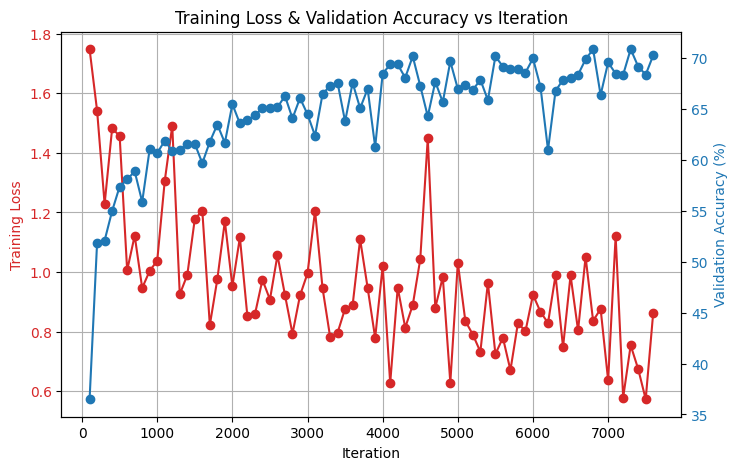

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.7481187582015991,
  1.5416585206985474,
  1.228186845779419,
  1.4823541641235352,
  1.4569201469421387,
  1.005549430847168,
  1.1221784353256226,
  0.9464356303215027,
  1.0040104389190674,
  1.0380347967147827,
  1.305653691291809,
  1.4910979270935059,
  0.9250611662864685,
  0.9899628758430481,
  1.1778347492218018,
  1.2058329582214355,
  0.8216369152069092,
  0.976

In [104]:
channel_1 = 32
channel_2 = 16
learning_rate = 0.0015

model = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 ----
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (32→16)

    # ---- Conv block 2 ----
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (16→8)

    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2 * 8 * 8, 10)          # fixed input size
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_part34(model, optimizer, epochs=10)


### Smaller filters

Epoch 1/10
[Iter 100] loss = 1.5306
   validation accuracy: 39.70%
[Iter 200] loss = 1.3458
   validation accuracy: 50.00%
[Iter 300] loss = 1.3779
   validation accuracy: 54.10%
[Iter 400] loss = 1.6534
   validation accuracy: 56.70%
[Iter 500] loss = 1.4009
   validation accuracy: 56.10%
[Iter 600] loss = 0.9995
   validation accuracy: 57.00%
[Iter 700] loss = 1.0122
   validation accuracy: 59.80%

Epoch 2/10
[Iter 800] loss = 1.1051
   validation accuracy: 54.80%
[Iter 900] loss = 1.0380
   validation accuracy: 58.50%
[Iter 1000] loss = 1.0747
   validation accuracy: 59.30%
[Iter 1100] loss = 1.0184
   validation accuracy: 60.40%
[Iter 1200] loss = 0.9315
   validation accuracy: 62.20%
[Iter 1300] loss = 1.0326
   validation accuracy: 62.70%
[Iter 1400] loss = 1.0479
   validation accuracy: 60.10%
[Iter 1500] loss = 1.1582
   validation accuracy: 61.50%

Epoch 3/10
[Iter 1600] loss = 0.9547
   validation accuracy: 58.10%
[Iter 1700] loss = 0.9890
   validation accuracy: 61.80%
[Iter

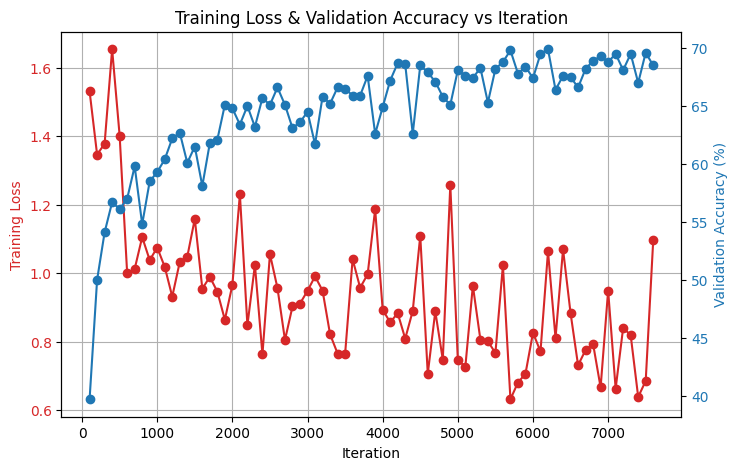

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.5306475162506104,
  1.3457942008972168,
  1.3778921365737915,
  1.6534079313278198,
  1.400915265083313,
  0.9994821548461914,
  1.0122294425964355,
  1.1050810813903809,
  1.0380078554153442,
  1.0746649503707886,
  1.0183513164520264,
  0.931460976600647,
  1.0325993299484253,
  1.0478978157043457,
  1.1582385301589966,
  0.954685628414154,
  0.9890426993370056,
  0.945

In [105]:
channel_1 = 32
channel_2 = 16
learning_rate = 0.0015

model = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 (3x3) ----
    nn.Conv2d(3, channel_1, kernel_size=3, padding=1),  # 32x32 -> 32x32
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),              # 32x32 -> 16x16

    # ---- Conv block 2 (still 3x3) ----
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),  # 16x16 -> 16x16
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),                      # 16x16 -> 8x8

    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2 * 8 * 8, 10),
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_part34(model, optimizer, epochs=10)


### Global average pooling

Epoch 1/10
[Iter 100] loss = 1.9217
   validation accuracy: 26.80%
[Iter 200] loss = 1.7316
   validation accuracy: 29.40%
[Iter 300] loss = 1.5790
   validation accuracy: 36.30%
[Iter 400] loss = 1.8324
   validation accuracy: 38.70%
[Iter 500] loss = 1.6536
   validation accuracy: 43.10%
[Iter 600] loss = 1.5831
   validation accuracy: 42.50%
[Iter 700] loss = 1.6919
   validation accuracy: 44.90%

Epoch 2/10
[Iter 800] loss = 1.8604
   validation accuracy: 35.60%
[Iter 900] loss = 1.6825
   validation accuracy: 43.10%
[Iter 1000] loss = 1.6309
   validation accuracy: 41.90%
[Iter 1100] loss = 1.4826
   validation accuracy: 40.80%
[Iter 1200] loss = 1.4717
   validation accuracy: 44.20%
[Iter 1300] loss = 1.5040
   validation accuracy: 43.10%
[Iter 1400] loss = 1.4335
   validation accuracy: 44.20%
[Iter 1500] loss = 1.5169
   validation accuracy: 46.40%

⚠️ Training interrupted by user. Plotting collected results...



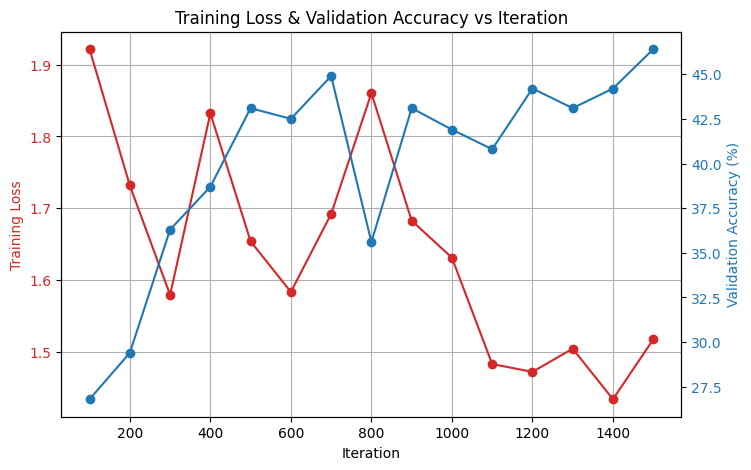

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500],
 'train_loss': [1.9216556549072266,
  1.7316076755523682,
  1.5790174007415771,
  1.832373857498169,
  1.653632402420044,
  1.5831457376480103,
  1.6918652057647705,
  1.860390067100525,
  1.68252694606781,
  1.6308808326721191,
  1.4825737476348877,
  1.4716668128967285,
  1.5039688348770142,
  1.4335230588912964,
  1.5168951749801636],
 'val_acc': [0.268,
  0.294,
  0.363,
  0.387,
  0.431,
  0.425,
  0.449,
  0.356,
  0.431,
  0.419,
  0.408,
  0.442,
  0.431,
  0.442,
  0.464]}

In [106]:
channel_1 = 32
channel_2 = 16
learning_rate = 0.0015

model_2 = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 ----
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (32→16)

    # ---- Conv block 2 ----
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (16→8)

    nn.AdaptiveAvgPool2d(1),

    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2, 10)          # fixed input size
)

optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

train_part34(model_2, optimizer, epochs=10)


### More filters

Epoch 1/10
[Iter 100] loss = 1.2665
   validation accuracy: 45.20%
[Iter 200] loss = 1.3193
   validation accuracy: 53.10%
[Iter 300] loss = 1.3378
   validation accuracy: 53.60%
[Iter 400] loss = 1.1593
   validation accuracy: 58.30%
[Iter 500] loss = 1.2493
   validation accuracy: 59.10%
[Iter 600] loss = 1.1247
   validation accuracy: 61.00%
[Iter 700] loss = 1.0210
   validation accuracy: 61.60%

Epoch 2/10
[Iter 800] loss = 1.0657
   validation accuracy: 55.90%
[Iter 900] loss = 0.9387
   validation accuracy: 63.20%
[Iter 1000] loss = 0.8082
   validation accuracy: 62.40%
[Iter 1100] loss = 0.9572
   validation accuracy: 63.20%
[Iter 1200] loss = 0.8609
   validation accuracy: 62.60%
[Iter 1300] loss = 0.9466
   validation accuracy: 64.10%
[Iter 1400] loss = 1.0684
   validation accuracy: 65.30%
[Iter 1500] loss = 0.7690
   validation accuracy: 60.90%

Epoch 3/10
[Iter 1600] loss = 1.5273
   validation accuracy: 58.20%
[Iter 1700] loss = 0.7911
   validation accuracy: 66.90%
[Iter

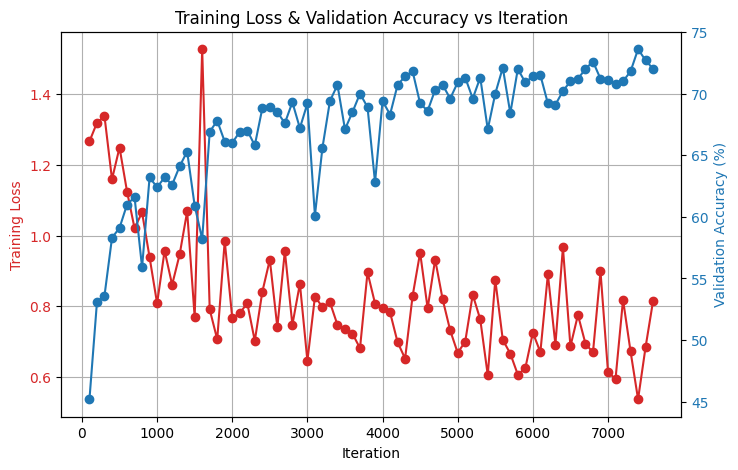

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.2665399312973022,
  1.319329023361206,
  1.3378102779388428,
  1.1593096256256104,
  1.2492562532424927,
  1.124678373336792,
  1.02096426486969,
  1.0656535625457764,
  0.9386648535728455,
  0.8081751465797424,
  0.9571780562400818,
  0.8609073162078857,
  0.9466073513031006,
  1.0683958530426025,
  0.7690119743347168,
  1.5273045301437378,
  0.7911257743835449,
  0.7064

In [107]:
channel_1 = 64
channel_2 = 32
learning_rate = 0.0015

model_3 = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 ----
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (32→16)

    # ---- Conv block 2 ----
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (16→8)

    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2 * 8 * 8, 10)          # fixed input size
)

optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

train_part34(model_3, optimizer, epochs=10)


Epoch 1/10
[Iter 100] loss = 1.5821
   validation accuracy: 42.00%
[Iter 200] loss = 1.5032
   validation accuracy: 51.80%
[Iter 300] loss = 1.4729
   validation accuracy: 54.50%
[Iter 400] loss = 1.0333
   validation accuracy: 58.20%
[Iter 500] loss = 1.0175
   validation accuracy: 60.50%
[Iter 600] loss = 0.8856
   validation accuracy: 60.10%
[Iter 700] loss = 1.2540
   validation accuracy: 60.30%

Epoch 2/10
[Iter 800] loss = 1.4549
   validation accuracy: 50.40%
[Iter 900] loss = 1.1711
   validation accuracy: 63.30%
[Iter 1000] loss = 0.8275
   validation accuracy: 63.50%
[Iter 1100] loss = 0.6845
   validation accuracy: 62.90%
[Iter 1200] loss = 0.9602
   validation accuracy: 63.50%
[Iter 1300] loss = 0.9860
   validation accuracy: 65.40%
[Iter 1400] loss = 0.9982
   validation accuracy: 66.40%
[Iter 1500] loss = 0.8733
   validation accuracy: 69.10%

Epoch 3/10
[Iter 1600] loss = 0.9594
   validation accuracy: 61.90%
[Iter 1700] loss = 0.7531
   validation accuracy: 66.90%
[Iter

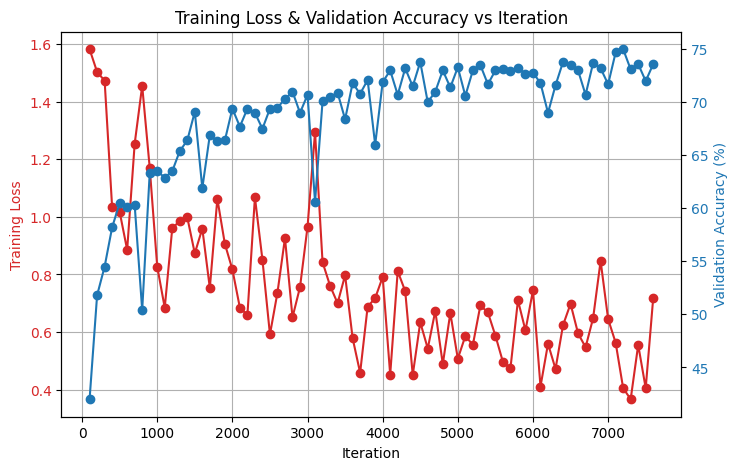

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.5821073055267334,
  1.5032105445861816,
  1.472895860671997,
  1.0332878828048706,
  1.0174860954284668,
  0.8855591416358948,
  1.254008173942566,
  1.4549424648284912,
  1.1710809469223022,
  0.8274682760238647,
  0.6844731569290161,
  0.9602428674697876,
  0.9860376119613647,
  0.9982133507728577,
  0.8732973337173462,
  0.959439754486084,
  0.7531006336212158,
  1.062

In [109]:
channel_1 = 96
channel_2 = 64
learning_rate = 0.0015

CNN_96_64 = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 ----
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (32→16)

    # ---- Conv block 2 ----
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (16→8)

    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2 * 8 * 8, 10)          # fixed input size
)

optimizer = optim.Adam(CNN_96_64.parameters(), lr=learning_rate)

train_part34(CNN_96_64, optimizer, epochs=10)


### Many filters + global average pooling

Epoch 1/10
[Iter 100] loss = 1.8594
   validation accuracy: 27.70%
[Iter 200] loss = 1.7020
   validation accuracy: 42.50%
[Iter 300] loss = 1.8179
   validation accuracy: 44.90%
[Iter 400] loss = 1.7860
   validation accuracy: 46.60%

⚠️ Training interrupted by user. Plotting collected results...



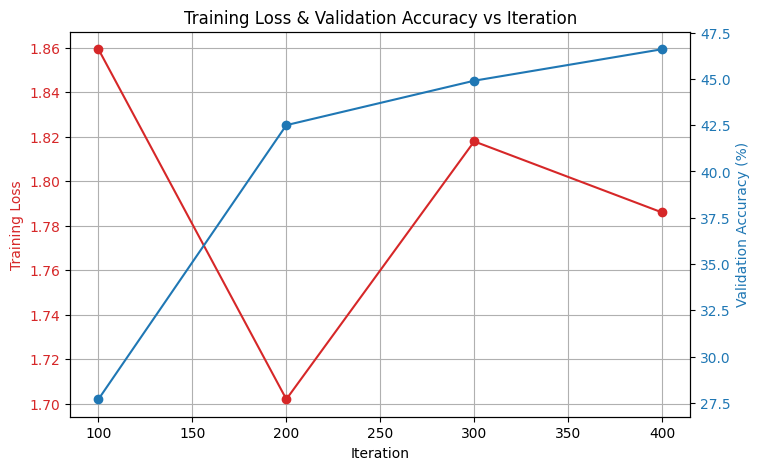

{'iter': [100, 200, 300, 400],
 'train_loss': [1.859390377998352,
  1.7019792795181274,
  1.8179347515106201,
  1.7859762907028198],
 'val_acc': [0.277, 0.425, 0.449, 0.466]}

In [110]:
channel_1 = 96
channel_2 = 64
learning_rate = 0.0015

CNN_96_64_GAP = nn.Sequential(
    UnflattenCIFAR(),
    
    # ---- Conv block 1 ----
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (32→16)

    # ---- Conv block 2 ----
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.MaxPool2d(kernel_size=2, stride=2),   # <--- added pooling  (16→8)

    nn.AdaptiveAvgPool2d(1),
    Flatten(),

    # ---- Fully connected ----
    nn.Linear(channel_2, 10)          # fixed input size
)

optimizer = optim.Adam(CNN_96_64_GAP.parameters(), lr=learning_rate)

train_part34(CNN_96_64_GAP, optimizer, epochs=10)


### ResNet

In [120]:
class ResNetBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(planes),
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        out = self.main(x) + self.shortcut(x)
        return F.relu(out, inplace=True)


In [123]:
channel_1 = 32
channel_2 = 16
num_classes = 10

ResNet96_64 = nn.Sequential(
    UnflattenCIFAR(),  # (N, 3072) -> (N, 3, 32, 32)

    # Stem
    nn.Conv2d(3, channel_1, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(inplace=True),

    # Block 1: keep 32x32, 96 -> 96
    ResNetBlock(channel_1, channel_1, stride=1),

    # Block 2: 32x32 -> 16x16, 96 -> 64
    ResNetBlock(channel_1, channel_2, stride=2),

    # Block 3: 16x16 -> 8x8, 64 -> 64
    ResNetBlock(channel_2, channel_2, stride=2),

    Flatten(),  # (N, 64 * 8 * 8)

    nn.Linear(channel_2 * 8 * 8, num_classes),
)


Epoch 1/10
[Iter 100] loss = 1.7071
   validation accuracy: 37.00%
[Iter 200] loss = 1.6073
   validation accuracy: 48.60%
[Iter 300] loss = 1.3902
   validation accuracy: 55.00%
[Iter 400] loss = 1.3026
   validation accuracy: 54.60%
[Iter 500] loss = 1.4594
   validation accuracy: 53.90%
[Iter 600] loss = 1.2206
   validation accuracy: 58.20%
[Iter 700] loss = 1.0672
   validation accuracy: 61.00%

Epoch 2/10
[Iter 800] loss = 1.0994
   validation accuracy: 54.20%
[Iter 900] loss = 1.0391
   validation accuracy: 61.50%
[Iter 1000] loss = 0.9917
   validation accuracy: 63.60%
[Iter 1100] loss = 0.9849
   validation accuracy: 63.40%
[Iter 1200] loss = 1.1381
   validation accuracy: 64.80%
[Iter 1300] loss = 1.1550
   validation accuracy: 66.70%
[Iter 1400] loss = 0.8394
   validation accuracy: 65.00%
[Iter 1500] loss = 0.7418
   validation accuracy: 65.00%

Epoch 3/10
[Iter 1600] loss = 1.1182
   validation accuracy: 64.10%
[Iter 1700] loss = 0.7521
   validation accuracy: 65.70%
[Iter

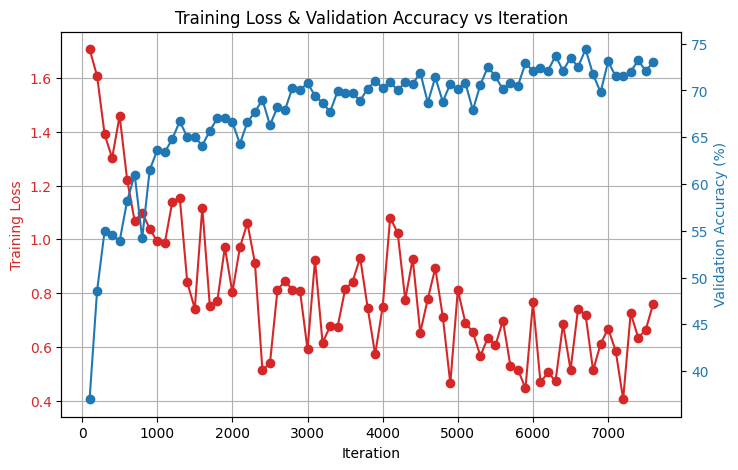

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.707091212272644,
  1.6072918176651,
  1.390176773071289,
  1.302577257156372,
  1.4594475030899048,
  1.2206363677978516,
  1.0671626329421997,
  1.0994341373443604,
  1.0391249656677246,
  0.9917305111885071,
  0.9848979711532593,
  1.1380653381347656,
  1.1550252437591553,
  0.8394267559051514,
  0.7418481707572937,
  1.118161678314209,
  0.7521290183067322,
  0.7710607

In [124]:
optimizer = optim.Adam(ResNet96_64.parameters(), lr=learning_rate)

train_part34(ResNet96_64, optimizer, epochs=10)

In [ ]:
channel_1 = 64
channel_2 = 32
num_classes = 10

ResNet64_32 = nn.Sequential(
    UnflattenCIFAR(),  # (N, 3072) -> (N, 3, 32, 32)

    # Stem
    nn.Conv2d(3, channel_1, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(inplace=True),

    # Block 1: keep 32x32, 96 -> 96
    ResNetBlock(channel_1, channel_1, stride=1),

    # Block 2: 32x32 -> 16x16, 96 -> 64
    ResNetBlock(channel_1, channel_2, stride=2),

    # Block 3: 16x16 -> 8x8, 64 -> 64
    ResNetBlock(channel_2, channel_2, stride=2),

    Flatten(),  # (N, 64 * 8 * 8)

    nn.Linear(channel_2 * 8 * 8, num_classes),
)


optimizer = optim.Adam(ResNet64_32.parameters(), lr=learning_rate)

train_part34(ResNet64_32, optimizer, epochs=10)

Epoch 1/10
[Iter 100] loss = 1.5381
   validation accuracy: 46.00%
[Iter 200] loss = 1.3462
   validation accuracy: 50.90%
[Iter 300] loss = 1.4861
   validation accuracy: 55.00%
[Iter 400] loss = 1.3119
   validation accuracy: 57.80%
[Iter 500] loss = 1.1975
   validation accuracy: 60.50%
[Iter 600] loss = 1.0391
   validation accuracy: 61.10%
[Iter 700] loss = 1.3096
   validation accuracy: 62.70%

Epoch 2/10
[Iter 800] loss = 1.0059
   validation accuracy: 58.20%
[Iter 900] loss = 0.7617
   validation accuracy: 64.00%
[Iter 1000] loss = 1.3561
   validation accuracy: 64.80%
[Iter 1100] loss = 0.7165
   validation accuracy: 67.70%
[Iter 1200] loss = 0.8654
   validation accuracy: 66.70%
[Iter 1300] loss = 0.9523
   validation accuracy: 67.00%
[Iter 1400] loss = 0.8439
   validation accuracy: 69.00%
[Iter 1500] loss = 1.0572
   validation accuracy: 71.20%

Epoch 3/10
[Iter 1600] loss = 0.9250
   validation accuracy: 68.30%
[Iter 1700] loss = 0.7703
   validation accuracy: 68.80%
[Iter